# Tarea 3: PINNs, Redes Recurrentes y Transformers

En esta Tarea Trabajaremos Con [Pytorch](https://pytorch.org/), una librería de Deep Learning de código abierto desarrollada por Facebook. Pytorch es una librería de Deep Learning que se basa en el concepto de [Tensores](https://pytorch.org/docs/stable/tensors.html), que son similares a los arreglos de Numpy, pero con la diferencia de que pueden ser utilizados en una GPU para acelerar los cálculos.

Se escogio Pytorch por sobre Tensorflow o Keras ya que tiene un paquete de [diferenciacion automatica](https://pytorch.org/docs/stable/autograd.html) que nos permite calcular derivadas de forma automatica, lo que nos permite implementar de forma sencilla los modelos de redes neuronales y sobre todo trabajar con PINNs y modificar pequeños detalles de forma sencilla en el lopp de entrenamiento como lo es aplicar custom losses, etc.

Dado que la ultima seccion del curso esta enfocado a trabajar con series temporales, todos los problemas en esta tarea de alguna u otra forma estan relacionados con series temporales o secuencias.

# 1. Imports

In [13]:
#data
import numpy as np
import pandas  as pd

# torch
import torch
import torch.nn as nn
import torch.nn.init as init
import torch.optim as optim
import torch.utils.data as data
import torch.nn.functional as F
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Preprocessing
from sklearn.preprocessing import MinMaxScaler

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# EDA
from sklearn.feature_selection import mutual_info_regression

# Evaluation
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_squared_log_error

device = 'cuda' if torch.cuda.is_available() else 'cpu'

torch.manual_seed(123)

En esta tarea tenemos 2 Secciones obligatorias, la parte de Redes Recurrentes y la Parte de Transformers, pero como no hay desafio Kaggle se añadio una seccion extra sobre PINNS (Physics Informed Neural Networks) la cual es opcional y sirve como bonus para la nota final.

Dado que no hay desafio Kaggle se incentiva a ser creativos y modificar los codigos, esto tambien añadira un bonus para la tarea.

# Parte 2: Redes Recurrentes

En esta tarea no hay desafio kaggle, por lo que en esta seccion deberan utilizar su creatividad para resolver un problema de series temporales, utilizando redes recurrentes.

## 2.1 Cargar Datos

In [14]:
train_df = pd.read_csv("DailyClimate_Train.csv")
test_df = pd.read_csv("DailyClimate_test.csv")

## 2.2 EDA & data Viz

En esta seccion deberan realizar un analisis exploratorio de los datos, generar visualizaciones que les permitan entender mejor los datos con los que estan trabajando y sacar conclusiones de estos.

In [15]:
train_df

,date,meantemp,humidity,wind_speed,meanpressure
0,2013-01-01,10.000000,84.500000,0.000000,1015.666667
1,2013-01-02,7.400000,92.000000,2.980000,1017.800000
2,2013-01-03,7.166667,87.000000,4.633333,1018.666667
3,2013-01-04,8.666667,71.333333,1.233333,1017.166667
4,2013-01-05,6.000000,86.833333,3.700000,1016.500000
...,...,...,...,...,...
1457,2016-12-28,17.217391,68.043478,3.547826,1015.565217
1458,2016-12-29,15.238095,87.857143,6.000000,1016.904762
1459,2016-12-30,14.095238,89.666667,6.266667,1017.904762
1460,2016-12-31,15.052632,87.000000,7.325000,1016.100000


In [16]:
test_df

,date,meantemp,humidity,wind_speed,meanpressure
0,2017-01-01,15.913043,85.869565,2.743478,59.000000
1,2017-01-02,18.500000,77.222222,2.894444,1018.277778
2,2017-01-03,17.111111,81.888889,4.016667,1018.333333
3,2017-01-04,18.700000,70.050000,4.545000,1015.700000
4,2017-01-05,18.388889,74.944444,3.300000,1014.333333
...,...,...,...,...,...
109,2017-04-20,34.500000,27.500000,5.562500,998.625000
110,2017-04-21,34.250000,39.375000,6.962500,999.875000
111,2017-04-22,32.900000,40.900000,8.890000,1001.600000
112,2017-04-23,32.875000,27.500000,9.962500,1002.125000


In [17]:
train_df_temp = train_df.copy()
train_df_temp['date'] = pd.to_datetime(train_df_temp['date'])

In [18]:
fig = px.line(train_df_temp, x='date', y='meantemp', markers=True, line_shape='linear')
fig.show()

In [19]:
scaler = MinMaxScaler()
columns = ['meantemp', 'humidity', 'wind_speed', 'meanpressure']
train_df_scaled = train_df.copy()
train_df_scaled[columns] = scaler.fit_transform(train_df[columns])
train_df_scaled
fig = px.line(train_df_scaled, x='date', y=['meantemp', 'humidity', 'wind_speed', 'meanpressure'], markers=True, line_shape='linear')
fig.update_layout(yaxis_title='Columns normalized')
fig.show()

In [20]:
fig = px.line(train_df, x='date', y='meanpressure', markers=True, line_shape='linear')
fig.show()

In [21]:
train_df_filtered = train_df[train_df['meanpressure'] <= 1349]
train_df_filtered = train_df_filtered[train_df_filtered['meanpressure'] >= 947]

fig = px.line(train_df_filtered, x='date', y='meanpressure', markers=True, line_shape='linear')
fig.show()

In [22]:
train_df.isna().sum()

date            0
meantemp        0
humidity        0
wind_speed      0
meanpressure    0
dtype: int64

### Anális de importancia de características

In [23]:
def preprocess_time(df, column, period):
    df['sin_'+column] = np.sin(2 * np.pi * df[column] / period)
    df['cos_'+column] = np.cos(2 * np.pi * df[column] / period)
    df.drop([column], axis=1, inplace=True)
    return df

train_df_temp = train_df.copy()
train_df_temp['date'] = pd.to_datetime(train_df_temp['date'])
train_df_temp['day'] = train_df_temp['date'].dt.day
train_df_temp['month'] = train_df_temp['date'].dt.month
train_df_temp['year'] = train_df_temp['date'].dt.year
train_df_temp.drop('date', inplace=True, axis=1)

train_df_temp = preprocess_time(train_df_temp, 'day', 31)
train_df_temp = preprocess_time(train_df_temp, 'month', 12)

In [24]:
target_variable = 'meantemp'
mutual_info_scores = []

for feature in train_df_temp.columns:
  if feature != target_variable:
    mi_score = mutual_info_regression(train_df_temp[[feature]], train_df_temp[target_variable])
    mutual_info_scores.append({'column': feature, 'score': mi_score[0]})

sorted(mutual_info_scores, key=lambda x: x['score'], reverse=True)

[{'column': 'meanpressure', 'score': 0.7837742194806778},
 {'column': 'cos_month', 'score': 0.63931281930157},
 {'column': 'sin_month', 'score': 0.45460164572427386},
 {'column': 'humidity', 'score': 0.3762948252346674},
 {'column': 'wind_speed', 'score': 0.07968458305757409},
 {'column': 'year', 'score': 0.0606458016578304},
 {'column': 'sin_day', 'score': 0.01167730988399951},
 {'column': 'cos_day', 'score': 0}]

In [25]:
from sklearn.ensemble import RandomForestRegressor

clf = RandomForestRegressor(n_estimators=100, random_state=42)
clf.fit(train_df_temp.drop('meantemp', axis=1), train_df_temp['meantemp'])

feature_importances = clf.feature_importances_
feature_importances

feature_importance_df = pd.DataFrame({'feature': train_df_temp.drop('meantemp', axis=1).columns, 'importance': feature_importances})
feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False)
feature_importance_df

,feature,importance
2,meanpressure,0.821886
0,humidity,0.074883
6,sin_month,0.035089
7,cos_month,0.024894
3,year,0.014868
4,sin_day,0.012323
5,cos_day,0.008138
1,wind_speed,0.007919


## 2.3 Preprocesamiento

En esta seccion deberan aplicar las transformaciones necesarias a los datos para poder entrenar su modelo, crear columnas, eliminar columnas, escalar los datos, etc.

In [26]:
def preprocess_dataframe(train, test):
  # Preprocess date
  train['date'] = pd.to_datetime(train['date'])
  train['day'] = train['date'].dt.day
  train['month'] = train['date'].dt.month
  train['year'] = train['date'].dt.year
  train.drop('date', inplace=True, axis=1)

  train = preprocess_time(train, 'day', 31)
  train = preprocess_time(train, 'month', 12)

  test['date'] = pd.to_datetime(test['date'])
  test['day'] = test['date'].dt.day
  test['month'] = test['date'].dt.month
  test['year'] = test['date'].dt.year
  test.drop('date', inplace=True, axis=1)

  test = preprocess_time(test, 'day', 31)
  test = preprocess_time(test, 'month', 12)

  # Preprocess other columns
  scaler = MinMaxScaler()
  columns = ['meantemp', 'humidity', 'wind_speed', 'meanpressure']
  train[columns] = scaler.fit_transform(train[columns])
  test[columns] = scaler.transform(test[columns])

  return train, test

In [27]:
train_df, test_df = preprocess_dataframe(train_df, test_df)

In [28]:
objective_col = 'meantemp' # columna objetivo
selected_cols = ['meanpressure', 'humidity', 'sin_month', 'cos_month']

In [29]:
# IMPORTANTE: agregamos la columna objetivo al final de la lista, deben asegurarse de que este al final para el correcto funcionamiento del codigo
selected_cols.append(objective_col)
selected_cols

['meanpressure', 'humidity', 'sin_month', 'cos_month', 'meantemp']

In [30]:
tr_timeseries = train_df[selected_cols].values.astype('float32')
te_timeseries = test_df[selected_cols].values.astype('float32')

In [31]:
# concatenamos los dataframes para despues hacer las visualizaciones, No borrar ni modificar
new = pd.concat([train_df, test_df], axis=0).reset_index().drop('index', axis=1)
new_timeseries = new[selected_cols].values.astype('float32')
shape = new_timeseries.shape[1]

## 2.4 Dataset y DataLoader

In [32]:
def create_dataset(dataset, lookback, shape):
    """Funcion para crear los tensores de entrenamiento y test
    dataset: np.ndarray
    lookback: int (numero de dias a considerar o largo de la secuencia)
    """
    X, y = [], []
    for i in range(len(dataset)-lookback):
        feature = dataset[:,:shape-1][i:i+lookback]
        target = dataset[:, shape-1][i:i+lookback]
        X.append(feature)
        y.append(target)
    # Convierte las listas a np.ndarray antes de convertirlas en tensores
    X = np.array(X)
    y = np.array(y)
    return torch.tensor(X), torch.tensor(y)

In [33]:
lookback = 7 #consideraremos los ultimos 7 dias para predecir el dia siguiente

train, test = tr_timeseries, te_timeseries
X_train, y_train = create_dataset(train, lookback=lookback, shape=shape)
X_test, y_test = create_dataset(test, lookback=lookback, shape=shape)

In [34]:
loader = data.DataLoader(data.TensorDataset(X_train, y_train), batch_size = 8, shuffle = True) #dataloader para entrenar los modelos de Pytorch

## 2.5 Modelo Recurrente

En esta seccion se implementa uan clase base para modelos recurrentes, pueden utilizar esta clase o pueden modificarla o crear una nueva clase si lo desean, recuerden que hay bonus por creatividad en esta tarea.

In [35]:
class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, dropout, bidirectional, rnn_class):
        super().__init__()
        # Verificar que rnn_class es una de las clases de RNN permitidas
        if rnn_class not in [nn.LSTM, nn.GRU, nn.RNN]:
            raise ValueError("rnn_class must be nn.LSTM, nn.GRU, or nn.RNN")

        # Inicializar la capa recurrente con la clase pasada como parámetro
        self.rnn = rnn_class(input_size=input_size,
                             hidden_size=hidden_size,
                             num_layers=num_layers,
                             batch_first=True,
                             bidirectional=bidirectional)

        # Calcular la dimensión de salida de la capa recurrente
        # Es doble si es bidireccional
        factor = 2 if bidirectional else 1

        self.dropout = nn.Dropout(p=dropout)
        self.linear1 = nn.Linear(hidden_size * factor, 64)
        self.linear2 = nn.Linear(64, hidden_size)
        self.output_linear = nn.Linear(hidden_size, 1)

    def forward(self, x):
        # LSTM devuelve (output, (h_n, c_n)) mientras que GRU y RNN solo devuelve (output, h_n)
        x, _ = self.rnn(x)
        x = self.dropout(x)
        x = self.linear1(x)
        x = self.linear2(x)
        x = self.output_linear(x)
        return x

## 2.6 Hiperparámetros

Aca pueden variar los hiperparametros de la red recurrente, pueden agregar mas si lo desean, para mas informacion sobre los optimizadores pueden revisar la documentacion de [pytorch Optim](https://pytorch.org/docs/stable/optim.html), y para mas informacion sobre los criterios de perdida pueden revisar la documentacion de [pytorch Loss](https://pytorch.org/docs/stable/nn.html#loss-functions)

In [36]:
# Hiperparametros del modelo
input_size = shape-1
hidden_size = 128
num_layers = 8
dropout = 0.2
bidirectional = True #puede ser True o False
layer_type = nn.RNN #puede ser nn.RNN, nn.LSTM o nn.GRU

# Modelo
model = RNNModel(input_size, hidden_size, num_layers, dropout, bidirectional, layer_type)

#optimizador
lr = 0.01
optimizer = optim.SGD(model.parameters(), lr=lr)

# loss func: MSE
loss_fn = nn.MSELoss()

## 2.7 Funciones de entrenamiento y evaluacion

En esta seccion se implementan funciones que nos ayudaran a entrenar y evaluar nuestro modelo, Pytorch no implementa metodos como .fit() por ende los tenemos que crear desde cero, al igual que antes sientanse libres de modificar o crear nuevas funciones, para mas informacion sobre el training loop pueden revisar la documentacion de [pytorch Custom Training](https://pytorch.org/tutorials/beginner/basics/optimization_tutorial.html#custom-training-loop)

In [37]:
class CustomEarlyStopping:
    """
    Funcion para detener el entrenamiento cuando la loss de validacion no mejora
    """
    def __init__(self, patience=20, delta=0, verbose=False):
        self.patience = patience
        self.delta = delta
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.best_state = None
        self.best_y_pred = None

    def __call__(self, val_loss, model, X):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.best_state = model.state_dict()
            with torch.no_grad():
                self.best_y_pred = model(X)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}, score: {self.best_score}')

            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.best_state = model.state_dict()
            with torch.no_grad():
                self.best_y_pred = model(X)
            self.counter = 0

In [38]:
def train_model(model, optimizer, early_stopping):
    """
    Funcion para entrenar el modelo
    """
    best_score = None
    best_weights = None

    n_epochs = 200

    for epoch in range(n_epochs):
        model.train() # Entrenamiento
        for X_batch, y_batch in loader:
            # Forward pass
            predictions = model(X_batch)

            # Compute loss
            loss = loss_fn(predictions.squeeze(), y_batch)

            # Zero gradients
            optimizer.zero_grad()

            # Backward pass
            loss.backward()

            # Update weights
            optimizer.step()

        model.eval() # Validacion
        with torch.no_grad():
            y_pred = model(X_train)
            train_rmse = np.sqrt(loss_fn(y_pred, y_train.unsqueeze(2)))

            y_pred = model(X_test)
            test_rmse = np.sqrt(loss_fn(y_pred, y_test.unsqueeze(2)))

            if best_score is None or test_rmse < best_score:
                best_score = test_rmse
                best_weights = model.state_dict()

            early_stopping(test_rmse, model, X_test)

            # Check if early stopping criterion is met
            if early_stopping.early_stop:
                print("Early stopping")
                break

        if epoch % 10 == 0:
            print('*'*10, 'Epoch: ', epoch, '\ train RMSE: ', train_rmse, '\ test RMSE', test_rmse)

    return model, best_weights

In [39]:
def get_preds(model, best_weights):
    """
    Funcion para obtener las predicciones y desnormalizarlas
    """
    # Usamos los mejores pesos para hacer las predicciones
    if best_weights is not None:
        model.load_state_dict(best_weights)

        # Calculamos las predicciones
        with torch.no_grad():
            y_pred_train = model(X_train).clone().detach().cpu().numpy()
            y_pred_test = model(X_test).clone().detach().cpu().numpy()

        # Modificamos las dimensiones de las predicciones para luego graficarlas
        with torch.no_grad():
            train_predictions = np.ones_like(new_timeseries) * np.nan
            train_predictions[lookback: len(train)] = y_pred_train[:,-1,:]

            test_predictions = np.ones_like(new_timeseries) * np.nan
            test_predictions[len(train)+lookback:len(new_timeseries)] = y_pred_test[:,-1,:]

        return train_predictions, test_predictions

In [40]:
def plot_predictions(train_predictions, test_predictions, shape):
    """
    Funcion para graficar las predicciones
    """
    # plot
    plt.figure(figsize=(20,10))
    plt.plot(new_timeseries[:,shape-1], c = 'b', label = 'True')
    plt.plot(train_predictions[:,shape-1], c='r', label = 'Train')
    plt.plot(test_predictions[:,shape-1], c='g', label = 'Test')
    plt.legend()
    plt.show()

In [41]:
def plot_eval(test_predictions, shape):
    """
    Funcion para graficar las predicciones
    """

    eval_df = pd.concat([test_df['meantemp'].reset_index(),pd.Series(test_predictions[:,shape-1][len(train):].reshape(-1).tolist())],axis=1).drop('index',axis=1) #creamos un dataframe con las predicciones y los valores reales

    eval_df.columns = ['real_meantemp', 'pred_meantemp'] #renombramos las columnas

    rmse = np.sqrt(mean_squared_error(eval_df.iloc[7:]['real_meantemp'], eval_df.iloc[7:]['pred_meantemp'])) #calculamos el rmse

    print(f'RMSE: {rmse}')

    fig = go.Figure(data = [
        go.Scatter(x = eval_df.index, y = eval_df['real_meantemp'], mode='lines', name = "Actual"),
        go.Scatter(x = eval_df.index, y = eval_df['pred_meantemp'], mode='lines', name="Predicted"),
    ])

    fig.update_layout(
        font = dict(size=17, family="Franklin Gothic"),
        template = 'simple_white',
        title = 'Real & Predicted Temperature'
    )

    fig.show()

## 2.8 Entrenamiento

In [42]:
early_stopping = CustomEarlyStopping(patience=15, verbose=True)
model, model_best_weights = train_model(model, optimizer, early_stopping)

********** Epoch:  0 \ train RMSE:  tensor(0.1056) \ test RMSE tensor(0.1078)
EarlyStopping counter: 1 out of 15, score: -0.08372952044010162
EarlyStopping counter: 2 out of 15, score: -0.08372952044010162
********** Epoch:  10 \ train RMSE:  tensor(0.0707) \ test RMSE tensor(0.0841)
EarlyStopping counter: 3 out of 15, score: -0.08372952044010162
EarlyStopping counter: 4 out of 15, score: -0.08372952044010162
EarlyStopping counter: 5 out of 15, score: -0.08372952044010162
EarlyStopping counter: 6 out of 15, score: -0.08372952044010162
EarlyStopping counter: 7 out of 15, score: -0.08372952044010162
EarlyStopping counter: 8 out of 15, score: -0.08372952044010162
EarlyStopping counter: 9 out of 15, score: -0.08372952044010162
EarlyStopping counter: 10 out of 15, score: -0.08372952044010162
EarlyStopping counter: 11 out of 15, score: -0.08372952044010162
EarlyStopping counter: 12 out of 15, score: -0.08372952044010162
********** Epoch:  20 \ train RMSE:  tensor(0.0699) \ test RMSE tensor(0

In [43]:
train_predictions, test_predictions = get_preds(model, model_best_weights)

## 2.9 Evaluacion

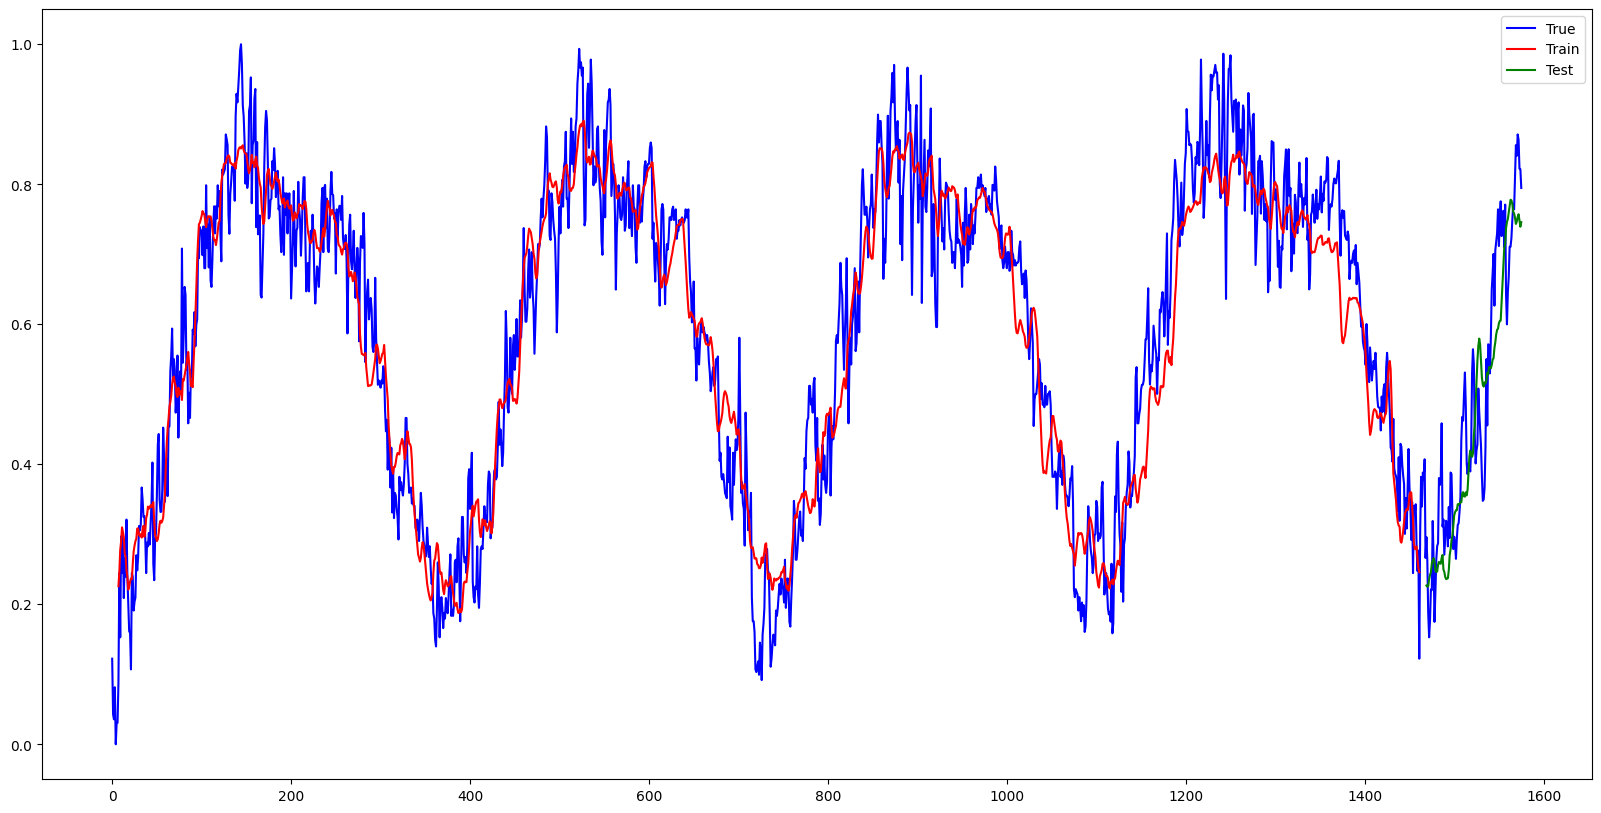

In [44]:
plot_predictions(train_predictions, test_predictions, shape)

In [45]:
plot_eval(test_predictions, shape)

RMSE: 0.09030039886854047


# Parte 3: Transformers

Para esta parte vamos a entrenar un transformer muy simple para que aprenda a generar texto como el del Quijote.

### 3.1 Cargar el dataset

In [5]:
with open('el_quijote.txt', 'r', encoding='utf-8') as f:
    text = f.read()

In [6]:
print("length of dataset in characters: ", len(text))

length of dataset in characters:  1038397


In [7]:
# Visualizamos los primeros 1000 caracteres
print(text[:1000])

DON QUIJOTE DE LA MANCHA
Miguel de Cervantes Saavedra

PRIMERA PARTE
CAPÍTULO 1: Que trata de la condición y ejercicio del famoso hidalgo D. Quijote de la Mancha
En un lugar de la Mancha, de cuyo nombre no quiero acordarme, no ha mucho tiempo que vivía un hidalgo de los de lanza en astillero, adarga antigua, rocín flaco y galgo corredor. Una olla de algo más vaca que carnero, salpicón las más noches, duelos y quebrantos los sábados, lentejas los viernes, algún palomino de añadidura los domingos, consumían las tres partes de su hacienda. El resto della concluían sayo de velarte, calzas de velludo para las fiestas con sus pantuflos de lo mismo, los días de entre semana se honraba con su vellori de lo más fino. Tenía en su casa una ama que pasaba de los cuarenta, y una sobrina que no llegaba a los veinte, y un mozo de campo y plaza, que así ensillaba el rocín como tomaba la podadera. Frisaba la edad de nuestro hidalgo con los cincuenta años, era de complexión recia, sec

### 3.2 Preprocesar el dataset

Vamos a crear un tokenizador muy simple que convierta el texto en una secuencia de números.

In [8]:
chars = list(set(text))
vocab_size = len(chars)
print('Caracteres unicos:',''.join(chars))
print('Largo del vocabulario:',vocab_size)

Caracteres unicos: ̃!]»tZ)4d1R.0pj”mSC'‘[B,<gos–6MA5:L9l3KHxWY2QaIE;yǹ8?́«u¡DGJV̈¿eN(vPq7 TbcO
UFrz-f’Xi"“h
Largo del vocabulario: 89


### 3.3 Encoding y Decoding

Ahora que tenemos el tokenizador, vamos a crear una función que nos permita convertir el texto en una secuencia de números y viceversa.

In [9]:
# Mapeamos cada caracter a un entero
stoi = { ch:i for i,ch in enumerate(chars) }
itos = { i:ch for i,ch in enumerate(chars) }
encode = lambda s: [stoi[c] for c in s] # encoder: toma un string, devuelve una lista de enteros
decode = lambda l: ''.join([itos[i] for i in l]) # decoder: toma una lista de enteros, devuelve un string

print(encode("Quijote de la Mancha"))
print(decode(encode("Quijote de la Mancha")))

[44, 56, 85, 14, 26, 4, 64, 71, 8, 64, 71, 36, 45, 71, 30, 45, 50, 74, 88, 45]
Quijote de la Mancha


**pregunta: Que otros tipos de tokenizaciones ademas de por caracteres existen y cuales serian las ventajas?**


* **Tokenización por subpalabras:** Tokeniza en base a segmentos de palabras. Conserva más información que por caracteres. Al mismo tiempo igual permite trabajar con palabras fuera del conjunto de entrenamiento.
* **Tokenización por palabras:** Tokeniza en función de palabras. Una ventaja que no permitiría generar palabras no válidas. Una desventaja es que hace díficil trabajar con palabras fuera del conjunto de entrenamiento.
* **Tokenización por sentencias:** Conserva aún más información que el anterior. Asegura que se generen frases válidas. En cuanto a desventajas es que se tiene aún menos granularidad.

Existen muchas formas de tokenización, estás son solo algunas.



**Pregunta: ¿que otras tecnicas se utilizan antes de tokenizar en problemas de NLP?**

Existe una gran variedad de técnicas que pueden utilizarse, entre ellas:

- **Convertir todo el texto a minúsculas:** Puede hacer más fácil producir resultados coherentes. Al mismo tiempo puede que se pierda información.
- **Eliminar puntuación:** Consiste en eliminar los elementos de puntuación. Puede ayudar a reducir el ruido. Al mismo tiempo, puede que se pierda información relevante.
- **Remover dígitos:** Puedo simplificar la input del modelo. Al mismo tiempo, dependiendo de la aplicación los números pueden ser relevantes.
- **Remover "Stopwords":** Consiste en la eliminación de palabras comunes sin mucho significado. Como por ejemplo conectores. La mayor desventaja es en que algunos casos se puede perder información relevante.
- **Lemmatization:** Consiste en homogenizar la representación de las palabras con significado parecido. Por ejemplo transformar "cantas" y "cantan" a "cantar".
- **Stemming:** Consiste en podar las palabras solo para dejar su parte más significativa. Por ejemplo en vez de transformar "cantas" y "cantan" a "cantar" se podrían transformar a "cant".
- **Aumentación de datos:** También podrían utilizarse técnicas de aumentación de datos enfocadas a texto.

### 3.4 Train y Val Split

In [10]:
# Vamos a Codificar el texto y llevarlo a un tensor de Pytorch
data = torch.tensor(encode(text), dtype=torch.long).to(device)

# Separamos en train y validation
n = int(0.7 * len(data))
train_data = data[:n]
val_data = data[n:]

print(train_data.shape, train_data.dtype)
print(train_data[:1000]) # los primeros 1000 caracteres del texto codificado

torch.Size([726877]) torch.int64
tensor([58, 75, 65, 71, 44, 77, 46, 60, 75, 72, 47, 71, 58, 47, 71, 34, 31, 71,
        30, 31, 65, 18, 39, 31, 76, 30, 85, 25, 56, 64, 36, 71,  8, 64, 71, 18,
        64, 79, 67, 45, 50,  4, 64, 27, 71, 17, 45, 45, 67, 64,  8, 79, 45, 76,
        76, 68, 10, 46, 30, 47, 10, 31, 71, 68, 31, 10, 72, 47, 76, 18, 31, 68,
        46, 54, 72, 77, 34, 75, 71,  9, 33, 71, 44, 56, 64, 71,  4, 79, 45,  4,
        45, 71,  8, 64, 71, 36, 45, 71, 74, 26, 50,  8, 85, 74, 85, 26, 54, 50,
        71, 49, 71, 64, 14, 64, 79, 74, 85, 74, 85, 26, 71,  8, 64, 36, 71, 82,
        45, 16, 26, 27, 26, 71, 88, 85,  8, 45, 36, 25, 26, 71, 58, 11, 71, 44,
        56, 85, 14, 26,  4, 64, 71,  8, 64, 71, 36, 45, 71, 30, 45, 50, 74, 88,
        45, 76, 47, 50, 71, 56, 50, 71, 36, 56, 25, 45, 79, 71,  8, 64, 71, 36,
        45, 71, 30, 45, 50, 74, 88, 45, 23, 71,  8, 64, 71, 74, 56, 49, 26, 71,
        50, 26, 16, 73, 79, 64, 71, 50, 26, 71, 69, 56, 85, 64, 79, 26, 71, 45,
       

### 3.5 Generando sequencias de texto

El transformer es una arquitectura de secuencias, por lo que necesitamos generar las secuencias de texto que vamos a utilizar para entrenar el modelo.

In [11]:
batch_size = 4 # cuantas secuencias de texto vamos a procesar en paralelo
block_size = 8 # definimos el largo de nuestra sequencia

def get_batch(split):
    # generamos un batch de datos
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    x, y = x.to(device), y.to(device)
    return x, y

In [12]:
xb, yb = get_batch('train')
print('inputs:')
print(xb.shape)
print(xb)
print('targets:')
print(yb.shape)
print(yb)

print('----')

for b in range(batch_size): # batch dimension
    for t in range(block_size): # time dimension
        context = xb[b, :t+1]
        target = yb[b,t]
        print(f"cuando el input es {context} el target es: {target}")

inputs:
torch.Size([4, 8])
tensor([[71, 50, 26, 71,  4, 85, 64, 50],
        [64, 50,  0, 26, 79, 71,  8, 64],
        [ 4, 45, 50,  4, 45, 27, 71, 88],
        [85, 26, 54, 53, 71, 63, 44, 56]], device='cuda:0')
targets:
torch.Size([4, 8])
tensor([[50, 26, 71,  4, 85, 64, 50, 64],
        [50,  0, 26, 79, 71,  8, 64, 71],
        [45, 50,  4, 45, 27, 71, 88, 45],
        [26, 54, 53, 71, 63, 44, 56, 64]], device='cuda:0')
----
cuando el input es tensor([71], device='cuda:0') el target es: 50
cuando el input es tensor([71, 50], device='cuda:0') el target es: 26
cuando el input es tensor([71, 50, 26], device='cuda:0') el target es: 71
cuando el input es tensor([71, 50, 26, 71], device='cuda:0') el target es: 4
cuando el input es tensor([71, 50, 26, 71,  4], device='cuda:0') el target es: 85
cuando el input es tensor([71, 50, 26, 71,  4, 85], device='cuda:0') el target es: 64
cuando el input es tensor([71, 50, 26, 71,  4, 85, 64], device='cuda:0') el target es: 50
cuando el input es tens

### 3.6 Creando el modelo

Vamos a crear un modelo naive que consiste en una capa de embedding, y una capa de salida que predice la siguiente palabra

In [ ]:
class BigramLanguageModel(nn.Module):

    def __init__(self, vocab_size):
        super().__init__()
        # cada token se representa como un vector de vocab_size dimensiones
        self.token_embedding_table = nn.Embedding(vocab_size, vocab_size)

    def forward(self, idx, targets=None):

        # idx y targets son (B, T) arrays de indices en el vocabulario
        logits = self.token_embedding_table(idx) # (B,T,C)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idx, max_new_tokens):
        for _ in range(max_new_tokens):
            logits, loss = self(idx)
            logits = logits[:, -1, :]
            probs = F.softmax(logits, dim=-1)
            idx_next = torch.multinomial(probs, num_samples=1)
            idx = torch.cat((idx, idx_next), dim=1)
        return idx

**Pregunta: Explique que hace la funcion Generate (indicar que hace cada linea de la funcion)**

**La función generate funciona de la siguiente manera:**
1. Repetir `max_new_tokens`veces:
2. Calcular prediccione y perdida del siguiente token a partir del input.
3. Obtener predicciones de el último token predicho. Este consiste en un vector de pesos de tamaño `vocab_size`.
3. Convertir pesos a probabilidades con la función `softmax`.
4. Se obtiene el último token predicho.
5. Se añade al input el token predicho. Luego se vuelve al paso 2 o se va al 6.
6. Retornar secuencia completa de predicciones


In [ ]:
# Hiperparametros
naive_model = BigramLanguageModel(vocab_size).to(device)
optimizer = optim.Adam(naive_model.parameters(), lr=0.001)
batch_size = 100000
epochs = 10

En esta seccion deberan crear un loop de entrenamiento para esto pueden revisar la documentacion de [Pytorch](https://pytorch.org/docs/stable/index.html)

In [ ]:
# Entrenamiento
for i in range(epochs):
    # obtenemos un batch de datos
    xb, yb = get_batch('train')

    # Obtenemos las predicciones del modelo y la loss
    logits, loss = naive_model(xb, yb)

    # reseteamos el gradiente
    optimizer.zero_grad()

    # Backward Pass
    loss.backward()

    # Actualizamos los pesos
    optimizer.step()

    # Visualizamos el resultado cada iteracion
    print(f"Epoch {i} | Loss {loss.item():.4f}")

Epoch 0 | Loss 4.9898
Epoch 1 | Loss 4.9883
Epoch 2 | Loss 4.9862
Epoch 3 | Loss 4.9870
Epoch 4 | Loss 4.9838
Epoch 5 | Loss 4.9793
Epoch 6 | Loss 4.9812
Epoch 7 | Loss 4.9773
Epoch 8 | Loss 4.9770
Epoch 9 | Loss 4.9753


In [ ]:
print('loss:', loss.item())
print(decode(naive_model.generate(idx = torch.zeros((1, 1), dtype=torch.long).to(device), max_new_tokens=100)[0].tolist()))

loss: 4.97526741027832
8q2KHuc9OTE?Xbq21bM«XGśDvcI<“aP[a7i5?0yF
4I]¿m‘BL<¡2Hl¡d‘7¿fh6-;)]2R8ag«¿5<hJJVRZ
SQnagGiMX1gfD“613T


Como vemos el modelo no es capaaz de generar texto coherente, para esto vamos a utilizar un transformer.

### 3.7 Transformer

El transformer es una arquitectura de secuencias que utiliza atención para poder capturar dependencias de largo plazo, en esta seccion deberan completar las lineas de codigo faltantes, para esto pueden revisar el paper originar [Attention is all you need](https://arxiv.org/pdf/1706.03762.pdf) y la documentacion de [Pytorch](https://pytorch.org/docs/stable/index.html)

In [ ]:
n_embd = 60
n_head = 8
n_layer = 2
dropout = 0.2

In [ ]:
class Head(nn.Module):
  """ cabezal de auto-atencion """

  def __init__(self, head_size):
    super().__init__()
    self.key = nn.Linear(head_size, head_size)
    self.query = nn.Linear(head_size, head_size)
    self.value = nn.Linear(head_size, head_size)
    self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))

    self.dropout = nn.Dropout(dropout)

  def forward(self, x):
    B,T,C = x.shape
    k = self.key(x)
    q = self.query(x)

    # Calcula la matriz de pesos (Afinidades)
    wei = q @ k.transpose(-2,-1) * C**-0.5 # (B, T, C) @ (B, C, T) -> (B, T, T)
    wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf')) # (B, T, T)
    softmax = F.softmax(wei, dim=-1)
    dropout = self.dropout(softmax)

    # Calcula la ponderacion de los valores por los pesos atencionales
    v = self.value(x)
    out = dropout @ v

    return out

**Pregunta: En sus propias palabras explique como funciona el mecanismo de auto-atencion**

La auto-atención consiste en generar un Key, Query y un Value por cada token del input. Estos consisten en proyecciones lineales realizadas con los mismos pesos por cada token.

 La Key y la Query de cada token es usada para calcular que tan similar es este a cada otro token en el input, incluyendo a si mismo. Luego su Value, que representa al token, es ponderado porque tanto es representado por cada token en el input.

 El resultado de esta última operación es llamado valores de auto-atención y es usado finalmente como representación del token.

In [ ]:
class MultiHeadAttention(nn.Module):
  """ Multiples cabezales de auto-atencion """

  def __init__(self, num_heads, head_size):
    super().__init__()
    self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
    self.proj = nn.Linear(num_heads * head_size, head_size)
    self.dropout = nn.Dropout(dropout)

  def forward(self, x):
    out = torch.cat([h(x) for h in self.heads], dim=-1)
    out = self.dropout(self.proj(out))
    return out

In [ ]:
class FeedFoward(nn.Module):
  """ Capa FeedForward """

  def __init__(self, n_embd):
    super().__init__()
    self.net = nn.Sequential(
      nn.Linear(n_embd, 512),
      nn.ReLU(),
      nn.Dropout(dropout),
      nn.Linear(512, n_embd),
      nn.Dropout(dropout)
    )

  def forward(self, x):
    return self.net(x)

In [ ]:
class Block(nn.Module):
  """ Bloque de Transformer """

  def __init__(self, n_embd, n_head):
    # n_embd: embedding dimension, n_head: the number of heads we'd like
    super().__init__()
    self.sa = MultiHeadAttention(n_head, n_embd)
    self.ffwd = FeedFoward(n_embd)
    self.ln1 = nn.LayerNorm(n_embd)
    self.ln2 = nn.LayerNorm(n_embd)

  def forward(self, x):
    x = x + self.sa(self.ln1(x))
    x = x + self.ffwd(self.ln2(x))
    return x

**Pregunta: Que parte del transformer estamos implementando?**

Implementa una parte del encoder de un transformer. Este puede ser combinado, como se hace más abajo, para crear el encoder.

In [ ]:
# Ahora definimos el modelo completo con los bloques de Transformer
class BigramLanguageModel(nn.Module):

  def __init__(self):
    super().__init__()
    self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
    self.position_embedding_table = nn.Embedding(block_size, n_embd)
    self.blocks = nn.Sequential(*[Block(n_embd, n_head=n_head) for _ in range(n_layer)])
    self.ln_f = nn.LayerNorm(n_embd) # final layer norm
    self.lm_head = nn.Linear(n_embd, vocab_size)

  def forward(self, idx, targets=None):
    B, T = idx.shape
    tok_emb = self.token_embedding_table(idx) # (B,T,C)
    pos_emb = self.position_embedding_table(torch.arange(T, device=device)) # (T,C)
    x = tok_emb + pos_emb # (B,T,C)
    x = self.blocks(x) # (B,T,C)
    x = self.ln_f(x) # (B,T,C)
    logits = self.lm_head(x) # (B,T,vocab_size)

    if targets is None:
      loss = None
    else:
      B, T, C = logits.shape
      logits = logits.view(B*T, C)
      targets = targets.view(B*T)
      loss = F.cross_entropy(logits, targets)

    return logits, loss

  def generate(self, idx, max_new_tokens):
    for _ in range(max_new_tokens):
      idx_cond = idx[:, -block_size:]
      logits, loss = self(idx_cond)
      logits = logits[:, -1, :] # (B, C)
      probs = F.softmax(logits, dim=-1) # (B, C)
      idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
      idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
    return idx

**Bonus: Desde que salio el transformer se han publicado mejoras para esta arquitectura, si implementan alguna mejora con la referencia del paper en cuestion obtendran un bonus, se atreven?**

In [ ]:
model = BigramLanguageModel()
m = model.to(device)

# Parametros del modelo
print(sum(p.numel() for p in m.parameters())/1e6, 'M parameters')

# Hiperparametros
lr = 0.001
optimizer = optim.Adam(model.parameters(), lr=lr)
epochs = 10000
eval_interval = 100
eval_iters = 200

0.369273 M parameters


In [ ]:
# Funcion de evaluar el modelo
@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

In [ ]:
for i in range(epochs):
    # cada 100 iteraciones evaluamos el modelo
    if i % eval_interval == 0 or i == epochs - 1:
        losses = estimate_loss()
        print(f"step {i}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")

    # Obtenemos un batch de datos
    xb, yb = get_batch('train')

    # Obtener las predicciones del modelo y la loss
    logits, loss = model(xb, yb)

    # reseteamos el gradiente
    optimizer.zero_grad()

    # Backward Pass
    loss.backward()

    # Actualizamos los pesos
    optimizer.step()

step 0: train loss 4.6073, val loss 4.6181
step 100: train loss 2.5938, val loss 2.6014
step 200: train loss 2.4336, val loss 2.4060
step 300: train loss 2.3499, val loss 2.3346
step 400: train loss 2.3034, val loss 2.2925
step 500: train loss 2.2939, val loss 2.2617
step 600: train loss 2.2269, val loss 2.2206
step 700: train loss 2.2257, val loss 2.2140
step 800: train loss 2.2045, val loss 2.2238
step 900: train loss 2.2053, val loss 2.1953
step 1000: train loss 2.1643, val loss 2.1852
step 1100: train loss 2.2008, val loss 2.1718
step 1200: train loss 2.1647, val loss 2.1852
step 1300: train loss 2.1621, val loss 2.1593
step 1400: train loss 2.1564, val loss 2.1569
step 1500: train loss 2.1852, val loss 2.1460
step 1600: train loss 2.1530, val loss 2.1546
step 1700: train loss 2.1373, val loss 2.1470
step 1800: train loss 2.1264, val loss 2.1338
step 1900: train loss 2.1019, val loss 2.1422
step 2000: train loss 2.1003, val loss 2.1242
step 2100: train loss 2.0932, val loss 2.0962


In [ ]:
# Generamos las predicciones
context = torch.zeros((1, 1), dtype=torch.long, device=device)
print(decode(m.generate(context, max_new_tokens=2000)[0].tolist()))

Poner a hacueranadra de los en grojo en tasus so le sejaberrón sende pusando,no, afenes, don quio yoto que Noque aterguno harado en el como que oy enchacerian las amadidas anto mis el quempojotos.
Mor antradiore en en esarota es parsebla, y caseño erdión sue lego porqure a val auradaiós suncho le amponeracimelmay corrasepás vazar cantarsas atre de la a ancos camedo lo pror de ten go y acher adellos bur En alla lo digrĩon es bajejo: harre los se endo, que yo los higaere leda he me dis ú su acóra fujoferrio todanus que sendra-re o quella enllól hadónes poi descon: Mate, premar de lal y o lletelloso rigon prebles le tin ma aurámpías e tid haba harre emo por se otis tos la tinada da pries ha mal ago balmáes, Lotabarra el maro.  que alla erabite, que carsón dijasas dibádario toh sabras alleran
meno panzáser la pese acuner ter hado; y que plariantieó tabachos yo que soy dujo no destar ombsar entadarion turán que, perq dutal senzandebre carásto a que lus en le comazo ha no 

Ahora las predicciones ya tienen un poco de sentido, podemos seguir entrenando el modelo para que genere texto más coherente y pueden utilizar el modelo cambiando el archivo de input para generar texto de otros libros o de lo que ustedes quieran.

# Bonus: Armonic Oscillator (PINN)

## Simular un oscilador armónico

Vamos a utilizar una red neuronal con física incorporada (PINN por sus siglas en inglés) para resolver problemas relacionados con el **oscilador armónico amortiguado**:

<img src="img/oscillator.gif" width="500">

Nos interesa modelar el desplazamiento de la masa en un resorte (caja verde) a lo largo del tiempo.

Este es un problema canónico de la física, donde el desplazamiento, $u(t)$, del oscilador como función del tiempo puede ser descrito por la siguiente ecuación diferencial:

$$
m \dfrac{d^2 u}{d t^2} + \mu \dfrac{d u}{d t} + ku = 0~,
$$

donde $ m $ es la masa del oscilador, $ \mu $ es el coeficiente de fricción y $ k $ es la constante del resorte.

Nos centraremos en resolver el problema en el estado **subamortiguado**, es decir, donde la oscilación es lentamente amortiguada por la fricción (como se muestra en la animación arriba).

Matemáticamente, esto ocurre cuando:

$$
\delta < \omega_0~,~~~~~\mathrm{donde}~~\delta = \dfrac{\mu}{2m}~,~\omega_0 = \sqrt{\dfrac{k}{m}}~.
$$

Además, consideramos las siguientes condiciones iniciales del sistema:

$$
u(t=0) = 1~~,~~\dfrac{d u}{d t}(t=0) = 0~.
$$

Para este caso particular, la solución exacta es conocida y dada por:

$$
u(t) = e^{-\delta t}(2 A \cos(\phi + \omega t))~,~~~~~\mathrm{con}~~\omega=\sqrt{\omega_0^2 - \delta^2}~.
$$


### Definimos nuestra Red Neuronal

In [ ]:
class simple_ffn(nn.Module):
    "Definimos una red neuronal feed forward en PyTorch"
    def __init__(self, N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYERS):
        super().__init__()
        activation = nn.Tanh
        self.input = nn.Sequential(*[
                        nn.Linear(N_INPUT, N_HIDDEN),
                        activation()])
        self.hidden = nn.Sequential(*[
                        nn.Sequential(*[
                            nn.Linear(N_HIDDEN, N_HIDDEN),
                            activation()]) for _ in range(N_LAYERS-1)])
        self.output = nn.Linear(N_HIDDEN, N_OUTPUT)

    def forward(self, x):
        x = self.input(x)
        x = self.hidden(x)
        x = self.output(x)
        return x

*Pregunta: ¿Porque se utiliza Tanh como función de activación generalmente en las PINNs?*

###  Solucion Exacta

In [ ]:
def exact_solution(d, w0, t):
    "Define la solucion analitica del problema planteado"
    assert d < w0
    w = np.sqrt(w0**2-d**2)
    phi = np.arctan(-d/w)
    A = 1/(2*np.cos(phi))
    cos = torch.cos(phi+w*t)
    exp = torch.exp(-d*t)
    u = exp*2*A*cos
    return u

### Puntos de entrenamiento

In [ ]:
# Definimos los puntos para la condicion de borde
t_boundary = torch.tensor(0.).view(-1,1).requires_grad_(True)

# Definimos los puntos del dominio del problema
t_physics = torch.linspace(0,1,30).view(-1,1).requires_grad_(True)

# parametros del problema
d, w0 = 2, 20
mu, k = 2*d, w0**2

# Solucion Exacta para comparar con el resultado de la red neuronal
t_test = torch.linspace(0,1,300).view(-1,1)
u_exact = exact_solution(d, w0, t_test)

### Hiperparámetros y Modelo

In [ ]:
epochs = 15001
pinn = simple_ffn(N_INPUT=1, N_OUTPUT=1, N_HIDDEN=32, N_LAYERS=3)
optim = torch.optim.Adam(pinn.parameters(),lr=1e-3)
lambda1, lambda2 = 1e-1, 1e-4

### Entrenamiento

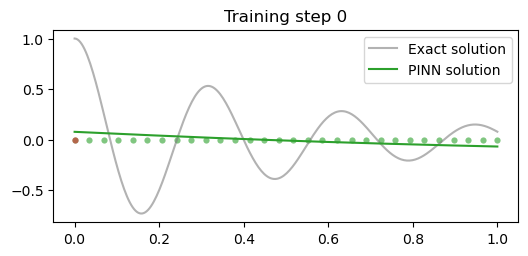

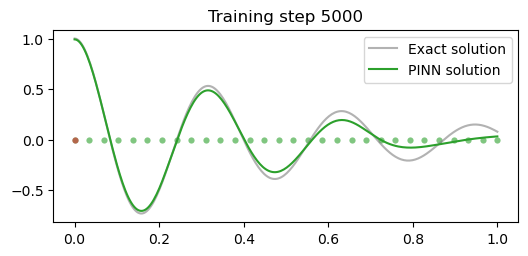

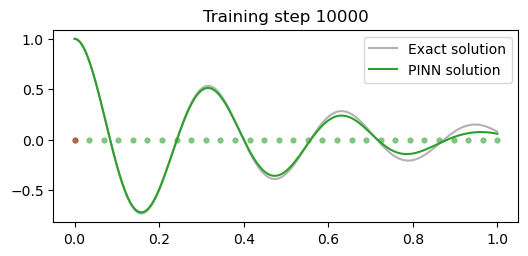

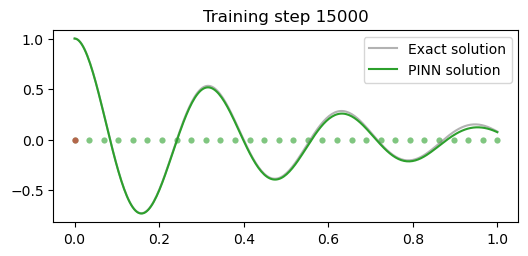

In [ ]:
for i in range(15001):
    optim.zero_grad() # reseteamos el gradiente

    # Calculamos la perdida de la condicion de borde
    u = pinn(t_boundary)
    loss1 = (torch.squeeze(u) - 1)**2
    dudt = torch.autograd.grad(u, t_boundary, torch.ones_like(u), create_graph=True)[0] # calculamos la derivada
    loss2 = (torch.squeeze(dudt) - 0)**2

    # Calculamos la perdida de la ecuacion diferencial
    u = pinn(t_physics)
    dudt = torch.autograd.grad(u, t_physics, torch.ones_like(u), create_graph=True)[0] # calculamos la derivada
    d2udt2 = torch.autograd.grad(dudt, t_physics, torch.ones_like(dudt), create_graph=True)[0] # calculamos la segunda derivada
    loss3 = torch.mean((d2udt2 + mu*dudt + k*u)**2)

    # Calculamos la perdida total (Custom Loss)
    loss = loss1 + lambda1*loss2 + lambda2*loss3

    # Backward Pass
    loss.backward()

    # Actualizamos los pesos
    optim.step()

    # Visualizamos el resultado cada 5000 iteraciones
    if i % 5000 == 0:
        u = pinn(t_test).detach()
        plt.figure(figsize=(6,2.5))
        plt.scatter(t_physics.detach()[:,0],
                    torch.zeros_like(t_physics)[:,0], s=20, lw=0, color="tab:green", alpha=0.6)
        plt.scatter(t_boundary.detach()[:,0],
                    torch.zeros_like(t_boundary)[:,0], s=20, lw=0, color="tab:red", alpha=0.6)
        plt.plot(t_test[:,0], u_exact[:,0], label="Exact solution", color="tab:grey", alpha=0.6)
        plt.plot(t_test[:,0], u[:,0], label="PINN solution", color="tab:green")
        plt.title(f"Training step {i}")
        plt.legend()
        plt.show()

## entrenar una PINN para invertir los parámetros subyacentes

La segunda tarea consiste en usar una PINN para **Estimar** parámetros.

Específicamente, nuestras entradas y salidas son:

- Entradas: observaciones con ruido del desplazamiento del oscilador
- Salidas: estimar $\mu$, el coeficiente de fricción

#### Enfoque

De manera similar a lo anterior, la PINN se entrena para aproximar directamente la solución a la ecuación diferencial, es decir

$$
u_{\mathrm{PINN}}(t;\theta) \approx u(t)~,
$$

donde $\theta$ son los parámetros libres de la PINN.

La idea clave aquí es también tratar $\mu$ como un **parámetro aprendible** al entrenar la PINN, de modo que simulamos la solución e invertimos para este parámetro.

#### Función de pérdida

La PINN se entrena con una función de pérdida ligeramente diferente:

$$
\mathcal{L}(\theta, \mu)= \frac{1}{N} \sum^{N}_{i} \left( \left[ m\frac{d^2}{dt^2} + \mu \frac{d}{dt} + k \right] u_{\mathrm{PINN}}(t_{i};\theta)  \right)^2 + \frac{\lambda}{M} \sum^{M}_{j} \left( u_{\mathrm{PINN}}(t_{j};\theta) - u_{\mathrm{obs}}(t_{j}) \right)^2
$$

#### Notas

Hay dos términos en la función de pérdida aquí. El primero es la **pérdida física**, formada de la misma manera que arriba, que asegura que la solución aprendida por la PINN es consistente con la física conocida.

El segundo término se llama **pérdida de datos**, y asegura que la solución aprendida por la PINN se ajuste a las observaciones de la solución (potencialmente con ruido) que están disponibles.

Nota, hemos eliminado los términos de pérdida de los bordes, ya que no los conocemos (es decir, solo se nos dan las mediciones observadas del sistema).

En esta configuración, los parámetros $\theta$ y $\mu$ de la PINN se aprenden **conjuntamente** durante la optimización.

Nuevamente, la autodiferenciación es nuestra amiga y nos permitirá definir fácilmente este problema.


### Puntos de Entrenamiento

True value of mu: 4


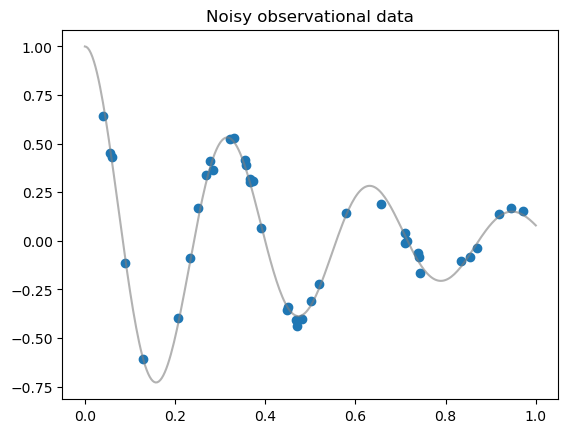

In [ ]:
# Creamos data con ruido
d, w0 = 2, 20
print(f"True value of mu: {2*d}")

# Definimos los puntos observacionales para que la red aprenda de los datos
t_obs = #TODO
u_obs = exact_solution(d, w0, t_obs) + 0.04*torch.randn_like(t_obs)

# definimos los puntos de entrenamiento sobre todo el dominio para la loss de la ecuacion diferencial
t_physics = #TODO

# parametros del problema
_, k = 2*d, w0**2

plt.figure()
plt.title("Noisy observational data")
plt.scatter(t_obs[:,0], u_obs[:,0])
t_test, u_exact = torch.linspace(0,1,300).view(-1,1), exact_solution(d, w0, t_test)
plt.plot(t_test[:,0], u_exact[:,0], label="Exact solution", color="tab:grey", alpha=0.6)
plt.show()

### Hiperparámetros y Modelo

In [ ]:
# Creamos un parametro entrenable para mu
mu = torch.nn.Parameter(torch.zeros(1, requires_grad=True))
mus = []

epochs = #TODO
pinn = #TODO
optim = torch.optim.Adam(list(pinn.parameters())+[mu],lr=1e-3)
lambda1 = 1e4

### Entrenamiento

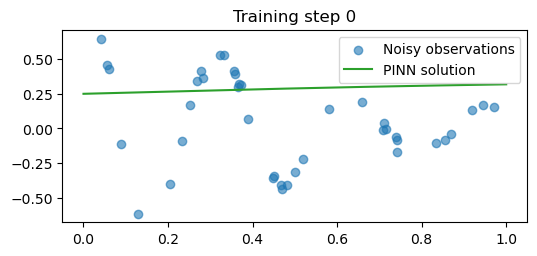

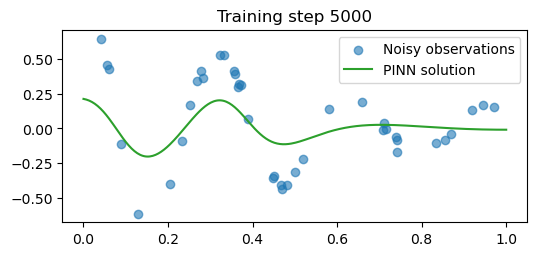

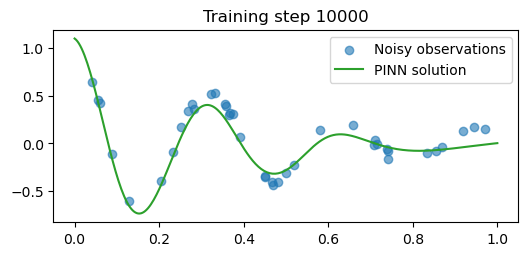

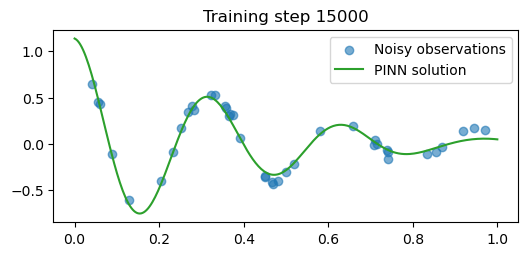

In [ ]:
for i in range(epochs):
    # reseteamos el gradiente
    #TODO

    # Calculamos la perdida de la ecuacion diferencial
    u = #TODO
    dudt = #TODO
    d2udt2 = #TODO
    loss1 = torch.mean((d2udt2 + mu*dudt + k*u)**2)

    # Calculamos la perdida en funcion de los datos
    u = #TODO
    loss2 = torch.mean((u - u_obs)**2)

    # Calculamos la perdida total (Custom Loss)
    loss = loss1 + lambda1*loss2

    # Backward Pass
    #TODO

    # Actualizamos los pesos
    #TODO

    # guardamos el valor de mu
    mus.append(mu.item())

    # Visualizamos el resultado cada 5000 iteraciones
    if i % 5000 == 0:
        u = pinn(t_test).detach()
        plt.figure(figsize=(6,2.5))
        plt.scatter(t_obs[:,0], u_obs[:,0], label="Noisy observations", alpha=0.6)
        plt.plot(t_test[:,0], u[:,0], label="PINN solution", color="tab:green")
        plt.title(f"Training step {i}")
        plt.legend()
        plt.show()

### Estimacion de $\mu$

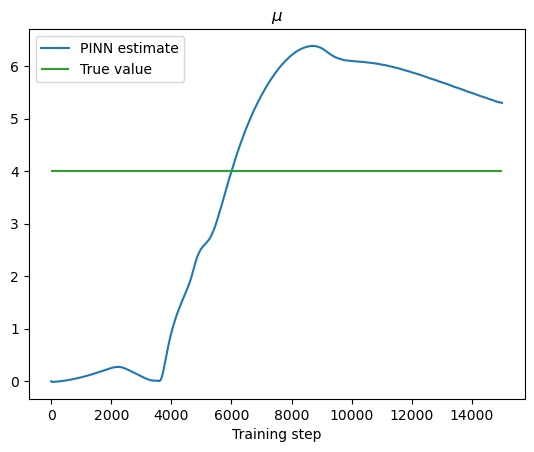

In [ ]:
plt.figure()
plt.title("$\mu$")
plt.plot(mus, label="PINN estimate")
plt.hlines(2*d, 0, len(mus), label="True value", color="tab:green")
plt.legend()
plt.xlabel("Training step")
plt.show()

## cómo escala la PINN a oscilaciones de mayor frecuencia



La tarea final es investigar cómo escala la PINN a oscilaciones de mayor frecuencia y qué se puede hacer para mejorar su convergencia.

Específicamente, volvemos a simular la solución al oscilador armónico e incrementamos su frecuencia, $\omega_0$.


la PINN lucha para converger, incluso si el número de puntos de entrenamiento físico aumenta.

Este es un problema más difícil para la PINN de resolver, en parte debido al **sesgo espectral** de las redes neuronales, así como al hecho de que se requieren más puntos de entrenamiento.

#### Enfoque: formulación alternativa "ansatz"

Para acelerar la convergencia, una forma es **asumir algo** sobre la solución.

Por ejemplo, supongamos que sabemos por nuestra intuición física que la solución es de hecho sinusoidal.

Entonces, en lugar de tener la PINN aproximando directamente la solución a la ecuación diferencial, es decir

$$
u_{\mathrm{PINN}}(t;\theta) \approx u(t)~,
$$

En su lugar, usamos la PINN como parte de un ansatz matemático de la solución, es decir

$$
\hat u(t; \theta, \alpha, \beta) = u_{\mathrm{PINN}}(t;\theta)  \sin (\alpha t + \beta) \approx u(t)~,
$$

donde $\alpha, \beta$ se tratan como parámetros adicionales aprendibles.

Comparando este ansatz con la solución exacta

$$
u(t) = e^{-\delta t}(2 A \cos(\phi + \omega t))
$$

Vemos que ahora la PINN solo necesita aprender la función exponencial, lo cual debería ser un problema mucho más fácil.

¡Una vez más, la autodiferenciación nos permite diferenciar fácilmente a través de este ansatz para entrenar la PINN!


### Puntos de Entrenamiento

In [ ]:
# Definimos los parametros A y B para la Ansatz
a = torch.nn.Parameter(70*torch.ones(1, requires_grad=True))
b = torch.nn.Parameter(torch.ones(1, requires_grad=True))

# Definimos los puntos de borde
t_boundary = #TODO

# Definimos los puntos de entrenamiento sobre todo el dominio para la loss de la ecuacion diferencial
t_physics = #TODO

# Parametros del problema
d, w0 = 2, 80 # las oscilaciones (w0) aumentaron
mu, k = 2*d, w0**2

# Solucion Exacta para comparar con el resultado de la red neuronal
t_test = torch.linspace(0,1,300).view(-1,1)
u_exact = exact_solution(d, w0, t_test)


### Hiperparámetros y Modelo

In [ ]:
pinn = #TODO
optim = #TODO
lambda1, lambda2 = 1e-1, 1e-4

### Entrenamiento

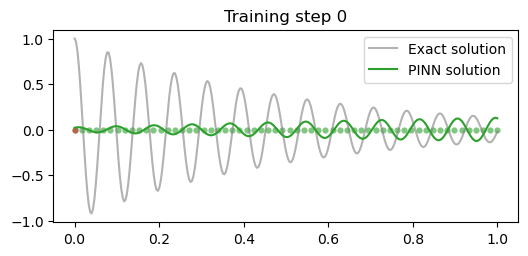

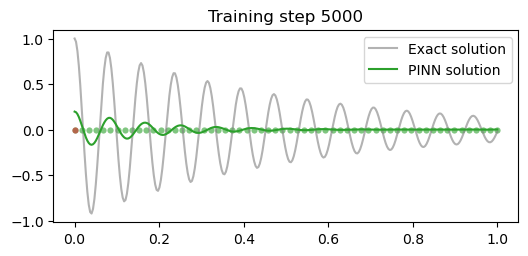

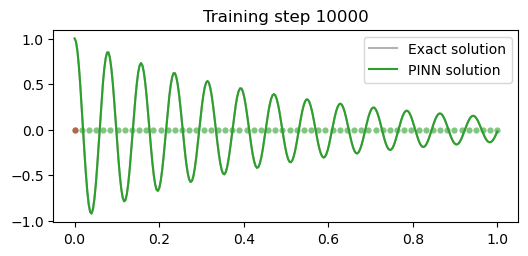

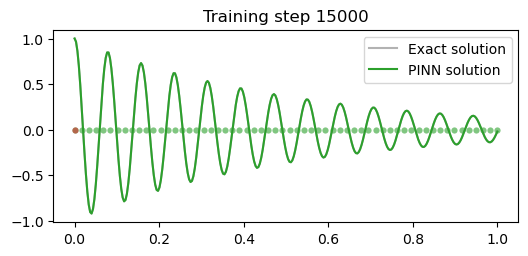

In [ ]:
for i in range(15001):
    # reseteamos el gradiente
    #TODO

    # Calculamos la perdida de la condicion de borde
    u = #TODO
    loss1 = #TODO
    dudt = #TODO
    loss2 = #TODO

    # Calculamos la perdida de la ecuacion diferencial
    u = #TODO
    dudt = #TODO
    d2udt2 = #TODO
    loss3 = #TODO

    # Calculamos la perdida total (Custom Loss)
    loss = loss1 + lambda1*loss2 + lambda2*loss3

    # Backward Pass
    #TODO

    # Actualizamos los pesos
    #TODO

    # Visualizamos el resultado cada 5000 iteraciones
    if i % 5000 == 0:
        u = (pinn(t_test)*torch.sin(a*t_test+b)).detach()
        plt.figure(figsize=(6,2.5))
        plt.scatter(t_physics.detach()[:,0],
                    torch.zeros_like(t_physics)[:,0], s=20, lw=0, color="tab:green", alpha=0.6)
        plt.scatter(t_boundary.detach()[:,0],
                    torch.zeros_like(t_boundary)[:,0], s=20, lw=0, color="tab:red", alpha=0.6)
        plt.plot(t_test[:,0], u_exact[:,0], label="Exact solution", color="tab:grey", alpha=0.6)
        plt.plot(t_test[:,0], u[:,0], label="PINN solution", color="tab:green")
        plt.title(f"Training step {i}")
        plt.legend()
        plt.show()